<center><h1>Time Series Data & Projections for Covid-19</h1>
    Stephen Webb</center>
    
This is a time series analysis of the spread of covid-19, based on data from Johns Hopkins University, <url> https://github.com/CSSEGISandData/COVID-19</url>, subject to this copyright notice:

>This GitHub repo and its contents herein, including all data, mapping, and analysis, copyright 2020 Johns Hopkins University, all rights reserved, is provided to the public strictly for educational and academic research purposes.  The Website relies upon publicly available data from multiple sources, that do not always agree. The Johns Hopkins University hereby disclaims any and all representations and warranties with respect to the Website, including accuracy, fitness for use, and merchantability.  Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.

The goal here is to try to understand the logistic growth curves of the various afflicted regions, and try to find similarities with the various US states to get a feel for how bad this could get and how long it would take to get there.

In [1]:
# Standard imports
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

from SIRmodel import SIRmodel

# using inline, have to set the figure bigger
%matplotlib inline

# set figure parameters so they look pretty
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (9.5, 6),
          'axes.labelsize': 12,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'axes.spines.right' : False,
          'axes.spines.left' : False,
          'axes.spines.top' : False,
          'axes.spines.bottom' : False}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

## Data Exploration

Read in and look at the available data for all the countries.

In [2]:
ts_data = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

cv19_confirmed = pd.read_csv(ts_data+'time_series_covid19_confirmed_global.csv')
cv19_deaths    = pd.read_csv(ts_data+'time_series_covid19_deaths_global.csv')
cv19_recovered = pd.read_csv(ts_data+'time_series_covid19_Recovered_global.csv')

# We want to use the dates as data in rows, so use the melt function
cv19_confirmed = cv19_confirmed.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")
cv19_deaths = cv19_deaths.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")
cv19_recovered = cv19_recovered.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")

# Convert the dates to datetime
cv19_confirmed['Date'] = pd.to_datetime(cv19_confirmed.Date)
cv19_deaths['Date'] = pd.to_datetime(cv19_deaths.Date)
cv19_recovered['Date'] = pd.to_datetime(cv19_recovered.Date)

# Take a look at the data
cv19_confirmed.head()
cv19_deaths.head()
cv19_recovered.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


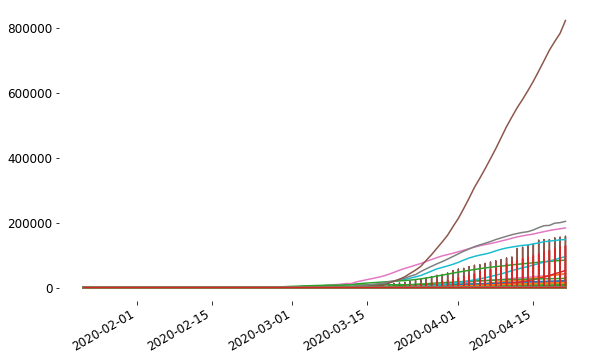

In [3]:
# Let's just look at a plot of the confirmed cases worldwide by date
fig, ax = plt.subplots();
for country in cv19_confirmed['Country/Region'].unique():
    if country != 'China':
        subframe = cv19_confirmed.loc[cv19_confirmed['Country/Region'] == country]
        ax.plot(subframe['Date'], subframe['Value']);
    
fig.autofmt_xdate()

fig.show();

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


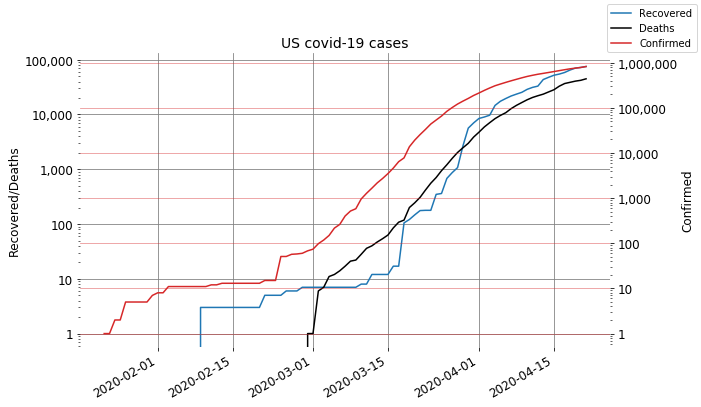

In [4]:
# Limit ourselves to the dates where someone was ill

subframe_conf    = cv19_confirmed.loc[cv19_confirmed['Country/Region'] == 'US']
subframe_rec     = cv19_recovered.loc[cv19_recovered['Country/Region'] == 'US']
subframe_deaths  = cv19_deaths.loc[cv19_deaths['Country/Region'] == 'US']

# Plot the US time series data


fig, ax = plt.subplots();

ax2 = ax.twinx()
ax2.semilogy(subframe_conf['Date'], subframe_conf['Value'], label='Confirmed', c='tab:red');
ax.semilogy(subframe_rec['Date'], subframe_rec['Value'], label='Recovered', c='tab:blue');
ax.semilogy(subframe_deaths['Date'], subframe_deaths['Value'], label='Deaths', c='k');
ax.set_ylabel('Recovered/Deaths')
ax2.set_ylabel('Confirmed')
ax.set_title('US covid-19 cases')
ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.legend()

fig.autofmt_xdate()
ax.grid(c='tab:gray')
ax2.grid(c='tab:red', alpha=0.5)
fig.show();

***
## Studying the Many States

The United States is acting more like 51 more-or-less independent entities with differing policies and responses, etc. It therefore makes sense to look at each of the states separately.

In [5]:
# a useful function
def compute_total_confirmed(df):
    """Computes the totals on a fixed date for a dataframe with multiple regions
    
    Returns:
    unique_dates : list
    total_values : list"""
    
    unique_dates = df['Date'].unique()
    total_values = [np.sum(df.loc[df['Date'] == date].Value) for date in unique_dates]

    
    return np.array(unique_dates), np.array(total_values)

In [6]:
# Read in the US data
cv19_confirmed_US = pd.read_csv(ts_data+'time_series_covid19_confirmed_us.csv')
cv19_deaths_US    = pd.read_csv(ts_data+'time_series_covid19_deaths_us.csv')

# Isolate the populations
pops = []
states = cv19_deaths_US.Province_State.unique()
for state in states:
    state_pop = cv19_deaths_US.loc[cv19_deaths_US['Province_State'] == state]['Population'].sum()
    pops.append(state_pop)

pops_df = pd.DataFrame()
pops_df['State'] = states
pops_df['Population'] = pops

# Remove the unused columns
cv19_confirmed_US = cv19_confirmed_US.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS','Lat', 'Long_', 'Combined_Key', 'Country_Region'], axis=1)
cv19_deaths_US = cv19_deaths_US.drop(labels=['Population', 'UID', 'iso2', 'iso3', 'code3', 'FIPS','Lat', 'Long_', 'Combined_Key', 'Country_Region'], axis=1)

In [7]:
# Create a new dataframe for state-level data
confirmed_dict = {}
deaths_dict = {}

for state in cv19_confirmed_US['Province_State'].unique():
    confirmed_dict[state] = cv19_confirmed_US.loc[
        cv19_confirmed_US['Province_State'] == state
            ].sum().drop(labels=['Admin2', 'Province_State'])
    confirmed_dict[state].index.name = 'Date'
    confirmed_dict[state] = confirmed_dict[state].reset_index()
    confirmed_dict[state].columns = ['Date','Value']
    confirmed_dict[state]['Date'] = pd.to_datetime(confirmed_dict[state].Date)
    
    deaths_dict[state] = cv19_deaths_US.loc[
        cv19_deaths_US['Province_State'] == state
            ].sum().drop(labels=['Admin2', 'Province_State'])
    deaths_dict[state].index.name = 'Date'
    deaths_dict[state] = deaths_dict[state].reset_index()
    deaths_dict[state].columns = ['Date','Value']
    deaths_dict[state]['Date'] = pd.to_datetime(deaths_dict[state].Date)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


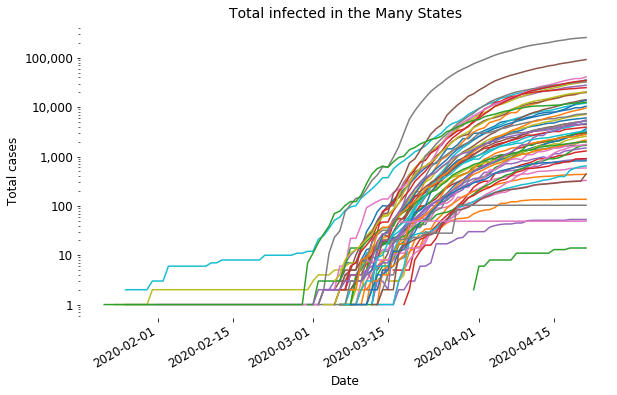

In [8]:
fig, ax = plt.subplots()

for state in states:
    pandemic_data = confirmed_dict[state].loc[confirmed_dict[state]['Value'] > 0]
    ax.semilogy( pandemic_data.Date, pandemic_data.Value);
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    
ax.set_xlabel('Date')
ax.set_ylabel('Total cases')
ax.set_title('Total infected in the Many States')
fig.autofmt_xdate()

fig.show();

***
## Fitting an SIR Model to Each State

To find out how long this is going to go on, we will fit an SIR model to each state, and tabulate the $R_0$ and variance in that value. This will give us state-by-state models for the progression of the pandemic in the US.

There is a real limit to this, which is that we don't have great statistics since the testing just isn't that thorough, but we have to assume it's indicative of the spread and we can start to extract an $R_0$ from it.

In [9]:
state_fits = {}
for state in states:
    print('Fitting {}'.format(state))
    N_pop = pops_df.loc[pops_df['State'] == state]['Population'].to_numpy()[0]
    print(' population: {}'.format(N_pop))
    if N_pop > 0: 
        state_fits[state] = {}
        state_model = SIRmodel(N_pop)
        confirmed_cases = np.array(confirmed_dict[state].to_numpy()[:,1], dtype=np.float64)
        # limit to only where the pandemic is happening
        pandemic_days = np.where(confirmed_cases > 0)[0]
        if len(pandemic_days) > 0:
            days = np.linspace(0, len(pandemic_days), len(pandemic_days))
            params, params_cov = curve_fit(
                state_model.run_reduced_model, 
                days, 
                confirmed_cases[pandemic_days],
                p0 = [2.5/14, 1])
            state_fits[state]['parameters'] = params
            state_fits[state]['covariance'] = params_cov
            state_fits[state]['upper'] = [params[0] + np.sqrt(params_cov[0,0]), params[1] + np.sqrt(params_cov[1,1])]
            state_fits[state]['lower'] = [params[0] - np.sqrt(params_cov[0,0]), params[1] - np.sqrt(params_cov[1,1])]
            print(' Fitting Parameters\n')
            print('    initial sick: {}'.format(params[1]))
            print('    R0          : {}\n'.format(params[0]))
            print('    covariance  : \n{}'.format(params_cov))
            print('****************')

Fitting American Samoa
 population: 55641
Fitting Guam
 population: 164229
 Fitting Parameters

    initial sick: 18.75073608064206
    R0          : 0.1056851704781303

    covariance  : 
[[ 9.33403653e-05 -2.51822410e-02]
 [-2.51822410e-02  6.99527690e+00]]
****************
Fitting Northern Mariana Islands
 population: 55144
 Fitting Parameters

    initial sick: 5.90490465201831
    R0          : 0.05623062970019291

    covariance  : 
[[ 4.29231787e-05 -2.65542854e-03]
 [-2.65542854e-03  1.84181873e-01]]
****************
Fitting Puerto Rico
 population: 2933408
 Fitting Parameters

    initial sick: 29.423680943186056
    R0          : 0.19547063544389953

    covariance  : 
[[ 2.47853741e-05 -1.37177147e-02]
 [-1.37177147e-02  7.79530289e+00]]
****************
Fitting Virgin Islands
 population: 107268
 Fitting Parameters

    initial sick: 7.452340216560862
    R0          : 0.10349355503204812

    covariance  : 
[[ 9.66342711e-05 -1.03409708e-02]
 [-1.03409708e-02  1.13997614e+

/Users/swebb/Documents/ml_projects/covid-19_outbreak/covid-19_analysis/notebooks/SIRmodel.py:36: RuntimeWarning: overflow encountered in double_scalars
  new_cases = r_0 * N_inf * (self.total_pop - N_rec - N_inf)/self.total_pop
/Users/swebb/Documents/ml_projects/covid-19_outbreak/covid-19_analysis/notebooks/SIRmodel.py:38: RuntimeWarning: invalid value encountered in double_scalars
  N_inf = N_inf - cured_cases + new_cases


 Fitting Parameters

    initial sick: 14.16353038414172
    R0          : 0.16080808643591574

    covariance  : 
[[ 4.16126120e-05 -1.02648453e-02]
 [-1.02648453e-02  2.59526480e+00]]
****************
Fitting Arizona
 population: 7278717
 Fitting Parameters

    initial sick: 1.1206995513540767
    R0          : 0.23686849187566822

    covariance  : 
[[ 6.32053895e-06 -4.77436370e-04]
 [-4.77436370e-04  3.64778240e-02]]
****************
Fitting Arkansas
 population: 3017804
 Fitting Parameters

    initial sick: 49.751345001736134
    R0          : 0.18283292506969134

    covariance  : 
[[ 5.87395837e-06 -5.59358955e-03]
 [-5.59358955e-03  5.46588652e+00]]
****************
Fitting California
 population: 39512223
 Fitting Parameters

    initial sick: 6.904072752149447
    R0          : 0.23768690458211564

    covariance  : 
[[ 4.48518558e-06 -2.09597455e-03]
 [-2.09597455e-03  9.90443559e-01]]
****************
Fitting Colorado
 population: 5758736
 Fitting Parameters

    initial

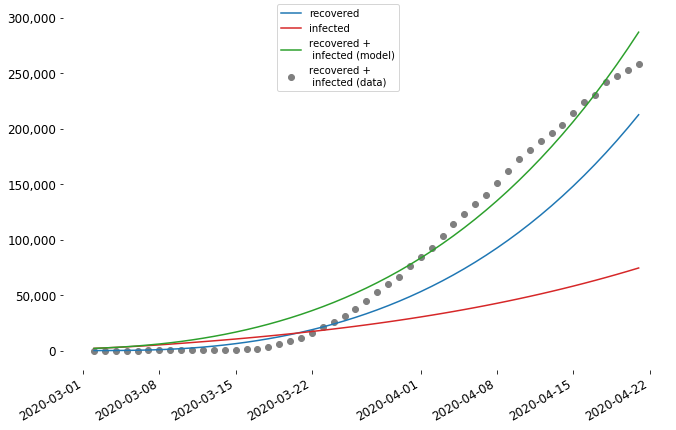

In [15]:
state = 'New York'
N_pop = pops_df.loc[pops_df['State'] == state]['Population'].to_numpy()[0]

state_model = SIRmodel(N_pop)
pandemic_days = np.where(confirmed_cases > 0)[0]

state_data = confirmed_dict[state].loc[confirmed_dict[state]['Value'] > 0]
confirmed_cases = np.array(confirmed_dict[state].to_numpy()[:,1], dtype=np.float64)
pandemic_days = np.where(confirmed_cases > 0)[0]
days = np.linspace(0, len(pandemic_days), len(pandemic_days))

N_infected, N_recovered = state_model.run_model(days, *state_fits[state]['parameters'])

fig, ax = plt.subplots()

ax.plot(state_data.Date[pandemic_days], N_recovered, c='tab:blue', label='recovered')
ax.plot(state_data.Date[pandemic_days], N_infected, c='tab:red', label='infected')
ax.plot(state_data.Date[pandemic_days], N_infected+N_recovered, c='tab:green', label='recovered +\n infected (model)')
ax.scatter(state_data.Date[pandemic_days], state_data.Value[pandemic_days], c='tab:gray', label='recovered +\n infected (data)')

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.legend(loc='upper center')
fig.autofmt_xdate()
fig.tight_layout();

In [ ]:
days = np.linspace(0, 180, 180)

N_infected, N_recovered = state_model.run_model(days, *state_fits[state]['parameters'])
N_infected_plus, N_recovered_plus = state_model.run_model(days, *state_fits[state]['upper'])
N_infected_minus, N_recovered_minus = state_model.run_model(days, *state_fits[state]['lower'])

fig, ax = plt.subplots()

ax.plot(days, N_infected, c='tab:red')
ax.plot(days, N_infected_plus, c='tab:orange')
ax.plot(days, N_infected_minus, c='tab:orange')

ax.plot(days, N_recovered, c='tab:blue')
ax.plot(days, N_recovered_plus, c='tab:gray')
ax.plot(days, N_recovered_minus, c='tab:gray')

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

## Mapping the Data

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [ ]:
usa = gpd.read_file('../figures/shapefiles/states/cb_2018_us_state_20m.shp')

In [ ]:
usa.head()

In [ ]:
usa.plot()